# <center>Analysis of Crime Incident Reports - Boston</center>

<center>Darshan Mehta</center>

In [121]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline
np.set_printoptions(suppress=True)
InteractiveShell.ast_node_interactivity = "all"

## Data Exploration and Cleaning

First we read the raw data file and the offense codes file from the `data/` folder. We then print the number of rows in each of the files. We also display a few top rows from the file to understand what the data looks like. 

In [2]:
raw_data = pd.read_csv('data/raw_data.csv')
offense_codes = pd.read_excel('data/rmsoffensecodes.xlsx')

print("Number of rows in raw_data file:", len(raw_data))
print("Number of rows in offense_codes file:", len(offense_codes))

Number of rows in raw_data file: 438757
Number of rows in offense_codes file: 576


In [3]:
raw_data.head() # Display the top 5 rows of raw data

offense_codes.head() # Display the top 5 rows of offense codes

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)"
1,I92089785,3005,NaN,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,NaN,WASHINGTON ST,NaN,NaN,"(0.00000000, 0.00000000)"
2,I90583827,1402,NaN,VANDALISM,E18,498,0,2019-11-02 05:09:00,2019,11,Saturday,5,NaN,BRADLEE ST,NaN,NaN,"(0.00000000, 0.00000000)"
3,I192082859,724,Auto Theft,AUTO THEFT,E18,519,NaN,2019-10-13 09:28:24,2019,10,Sunday,9,Part One,LINCOLN ST,42.259518,-71.121563,"(42.25951765, -71.12156299)"
4,I192082751,724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)"


,CODE,NAME
0,612,LARCENY PURSE SNATCH - NO FORCE
1,613,LARCENY SHOPLIFTING
2,615,LARCENY THEFT OF MV PARTS & ACCESSORIES
3,1731,INCEST
4,3111,LICENSE PREMISE VIOLATION


From the tables, we see that there are some redundant columns, for ex., `Location` is just a combination of `Lat` and `Long` and `OCCURED_ON_DATE` has been further broken down into `YEAR`, `MONTH`, etc. Let us drop the `Location` column for now and keep the other redundant columns. We will remove them later if we don't need them at all. We shall also convert the data type of OCCURED_ON_DATE to a datetime format for easy plotting.

In [4]:
raw_data = raw_data.drop(columns=['Location'])
raw_data['OCCURRED_ON_DATE'] = pd.to_datetime(raw_data['OCCURRED_ON_DATE'])

Now, let us verify if the number of Offense codes present in the offense codes dataset is the same as that in the raw_data file.

In [5]:
offense_offense_codes = set(offense_codes.CODE)
raw_data_offense_codes = set(raw_data.OFFENSE_CODE)

print("Number of unique offense codes in offense codes file:", len(offense_offense_codes))
print("Number of unique offense codes in raw_data file:", len(raw_data_offense_codes))

Number of unique offense codes in offense codes file: 425
Number of unique offense codes in raw_data file: 233


It is interesting there are no records for almost half of the offenses known to the system. Let us next make sure that the description for the offense codes present in both the files match for the common offenses present in both. That way, we can safely discard the offense codes file and only work with the raw_data file.

In [6]:
common_offense_codes = offense_offense_codes.intersection(raw_data_offense_codes)
print('There are a total of', len(common_offense_codes), "common offense codes.")

# Get a unique set of rows with common offense codes from raw_data
temp_data_raw = \
    raw_data[raw_data.OFFENSE_CODE.isin(common_offense_codes)][['OFFENSE_CODE', 
                                                                'OFFENSE_DESCRIPTION']]
temp_data_raw = temp_data_raw.drop_duplicates(subset=["OFFENSE_CODE"])

# Get a unique set of rows with common offense codes from offense dataset
temp_data_offense = offense_codes[offense_codes.CODE.isin(common_offense_codes)][['CODE', 'NAME']]
temp_data_offense = temp_data_offense.drop_duplicates(subset=["CODE"])

# join the two rows and display rows where names don't match
temp_merged_data = temp_data_offense.merge(temp_data_raw, left_on="CODE", right_on="OFFENSE_CODE")
temp_merged_data[temp_merged_data.NAME != temp_merged_data.OFFENSE_DESCRIPTION]

There are a total of 227 common offense codes.


,CODE,NAME,OFFENSE_CODE,OFFENSE_DESCRIPTION
42,244,RAPE - ATTEMPT - FONDLING,244,Fondling - Indecent Assault
43,241,RAPE - ATTEMPT - FORCIBLE,241,SEX OFFENSE - RAPE - FORCIBLE
44,243,RAPE - ATTEMPT - SEXUAL ASSAULT W/ OBJECT,243,SEX OFFENSE - RAPE - SEXUAL ASSAULT W/ OBJECT
45,261,RAPE - ATTEMPT - OTHER,261,SEX OFFENSE - RAPE - OTHER
179,531,B&E NON-RESIDENCE NIGHT - ATTEMPT FORCE,531,BREAKING AND ENTERING (B&E) MOTOR VEHICLE (NO ...
203,1848,DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP,1848,DRUGS - POSS CLASS D - INTENT TO MFR DIST DISP
207,1843,DRUGS - PRESENT AT HEROIN,1843,DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP
208,1847,DRUGS - TRAFFICKING IN COCAINE,1847,DRUGS - POSS CLASS C - INTENT TO MFR DIST DISP


We see that 6 codes are present in the raw_data with no corresponding record in the offense_codes file. We also see that for 8 of the common offense codes, the descriptions don't match perfectly. However, they are close enough, and judging by the values, it seems as if the description in the raw_data is more descriptive. So, we can safely discard the offense codes file.

Let us now analyze the percentage of null values in the raw_data columns.

In [7]:
print("Percentage of null values in each of the columns:")
raw_data.isnull().mean().sort_values(ascending=False) * 100

Percentage of null values in each of the columns:


SHOOTING               96.885748
Long                    8.916325
Lat                     8.916325
STREET                  3.110150
UCR_PART                2.741153
OFFENSE_CODE_GROUP      2.716082
DISTRICT                0.509621
HOUR                    0.000000
DAY_OF_WEEK             0.000000
MONTH                   0.000000
YEAR                    0.000000
OCCURRED_ON_DATE        0.000000
REPORTING_AREA          0.000000
OFFENSE_DESCRIPTION     0.000000
OFFENSE_CODE            0.000000
INCIDENT_NUMBER         0.000000
dtype: float64

As we see, there are a suprisingly high number of null values in the `SHOOTING` column. Upon further investigation, I found that this was because the incidents which were not associated with gun shooting were left as null. Let us look at the unique values in that column.

In [8]:
raw_data.SHOOTING.unique()

array(['0', nan, 'Y', '1'], dtype=object)

We need to clean up this column by setting all '0' and nan to False and the other two to True. And let us ignore the other null values for now, we will drop the corresponding rows later when we perform specific analysis on them.

In [9]:
raw_data['SHOOTING'] = raw_data.SHOOTING.replace({'0': False, np.nan: False, 'Y': True, '1': True})

Next, let's look at the summary of the columns to see if we find anything interesting in there.

In [10]:
raw_data.describe()

,OFFENSE_CODE,YEAR,MONTH,HOUR,Lat,Long
count,438757.000000,438757.000000,438757.000000,438757.000000,399636.000000,399636.000000
mean,2329.122469,2017.144207,6.743491,13.111722,42.221634,-70.920432
std,1181.869312,1.303589,3.287366,6.304673,2.084320,3.371579
min,111.000000,2015.000000,1.000000,0.000000,-1.000000,-71.178674
25%,1102.000000,2016.000000,4.000000,9.000000,42.297105,-71.097223
50%,3001.000000,2017.000000,7.000000,14.000000,42.325538,-71.077619
75%,3201.000000,2018.000000,9.000000,18.000000,42.348546,-71.062583
max,3831.000000,2019.000000,12.000000,23.000000,42.395042,-1.000000


Nothing specifically interesting here. One thing I noticed when we printed the top 5 rows of raw_data at the top was that there was a district named 'External'. This value denotes that the crime was reported outside of Boston, so we do not need this in our analysis. I also noticed that the disctricts had weird names, so when I further digged into the Boston Police Department website, I found a [page](https://bpdnews.com/districts) which mapped these coded names to the true district names. So, let's drop the 'External' records and create a new column `DISTRICT_NAME` with the mapped district names. 

In [11]:
raw_data = raw_data[raw_data.DISTRICT != 'External']

district_code_name_map = {
    'A1' : 'Downtown',
    'A7' : 'East Boston',
    'A15' : 'Charlestown',
    'B2' : 'Roxbury',
    'B3' : 'Mattapan',
    'C6' : 'South Boston',
    'C11' : 'Dorchester',
    'D4' : 'South End',
    'D14' : 'Brighton',
    'E5' : 'West Roxbury',
    'E13' : 'Jamaica Plain',
    'E18' : 'Hyde Park'
}

raw_data['DISTRICT_NAME'] = raw_data.DISTRICT.replace(district_code_name_map)

Next, let us have a look at the percentage of unique values in each column. This information is usually helpful in understanding if a feature has some information that could be derived.

In [12]:
raw_data.apply(lambda r: len(r.unique())) * 100 / len(raw_data)

INCIDENT_NUMBER        88.320151
OFFENSE_CODE            0.053108
OFFENSE_CODE_GROUP      0.015499
OFFENSE_DESCRIPTION     0.064504
DISTRICT                0.002963
REPORTING_AREA          0.200579
SHOOTING                0.000456
OCCURRED_ON_DATE       72.671347
YEAR                    0.001140
MONTH                   0.002735
DAY_OF_WEEK             0.001596
HOUR                    0.005470
UCR_PART                0.001140
STREET                  1.134867
Lat                     4.311308
Long                    4.311991
DISTRICT_NAME           0.002963
dtype: float64

The most shocking piece of information here is that the column `INCIDENT_NUMBER` is not 100\%. Upon further analysis, I found that there is an entry for each person involved in a crime report and for each offense. So if there were 5 people commited 2 kinds of offense together, there would be a total of 10 entries in the system instead of 2 or 1. This would clearly inflate the numbers in the dataset! We should remove the number of people factor from this to reduce the inflation amount. There should only be one entry per offense category for a certain incident. So we create a new dataset with the same setting. We retain the old dataset in case we wish to analyse the pattern in the number of people involved in crimes. We also offer a flag for someone who wishes to override the creation of this new dataset and wants to work with the inflated numbers.

In [13]:
uninflate_numbers = True  # Set to False if you wish to have the inflated numbers

if uninflate_numbers:
    processed_data = raw_data.drop_duplicates(subset=['INCIDENT_NUMBER', 'OFFENSE_CODE'], keep='first')
else:
    processed_data = raw_data.copy()

Now, the dataset description mentions that it contains crime reports lodged between Aug 2015 and Oct 2019. Since we plan to do year on year analysis for one of the questions, let us make sure we are aware of the dates in the dataset so we can accordingly modify our definition of `year`.

In [14]:
print('Earliest date:', processed_data.OCCURRED_ON_DATE.min())
print('Latest date:', processed_data.OCCURRED_ON_DATE.max())

Earliest date: 2015-06-15 00:00:00
Latest date: 2019-11-14 00:12:00


Now since the data starts from June 15, 2015, we will redefine the term `year` to be from 15th June of the previous year to 14th June of the next year for questions that perform analysis on this. And let us create another data file which would contain on the data till June 14, 2019.

In [15]:
subbed_data = processed_data[processed_data.OCCURRED_ON_DATE < '2019-06-15']

Now let us save the processed_data and subbed_data to a CSV file in the `data/` folder.

In [16]:
processed_data.to_csv('data/processed_data.csv', index=False)
subbed_data.to_csv('data/subbed_data.csv', index=False)

## Data Analysis

In this section, we aim to plot various aspects of data to see if we find something interesting. We also aim to answer the four main research questions:

1. What are the top 10 crimes classified for each district?
2. What are the top 10 crimes classified according to different times of the day?
3. Which reported incidents are most commonly associated with a shooting?
4. How have certain crimes changed in the past few years?

Let us first make a general plotting function which we could use for plotting histograms / distributions.

In [34]:
def plot_hist(data, x_label="", y_label="", title="", top=False):
    if top:
        data = data.sort_values(ascending=False)[:top]
    plt.rcParams["figure.figsize"] = [15, 10]
    plt.xticks(rotation=90)
    plt.plot(data)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)

In order to get a general sense of the field, let us have a look at the frequency of each kind of crime to understand which are the most common ones and which are the least.

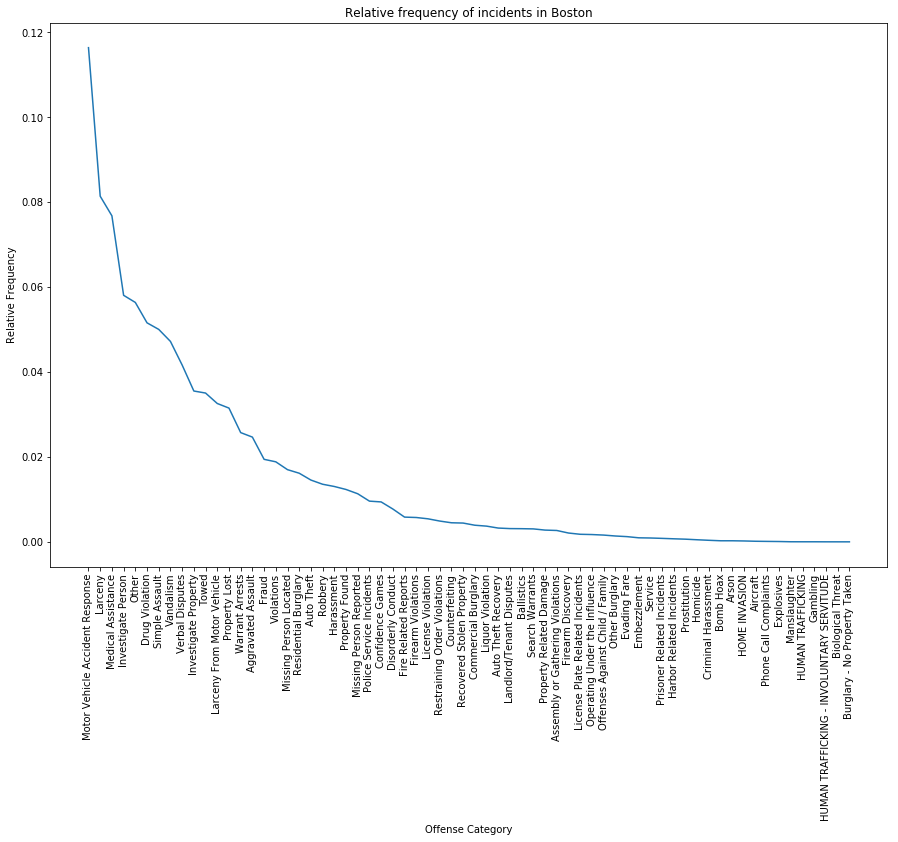

In [38]:
plot_hist(data=processed_data.OFFENSE_CODE_GROUP.value_counts(ascending=False, normalize=True, 
                                                              sort=True, dropna=True), 
          y_label="Relative Frequency", x_label="Offense Category", 
          title="Relative frequency of incidents in Boston")

It seems that Motor Vehicle Accidents and Larceny are some of the most commonly reported incidents and human trafficking is one of the least reported ones. Note here that just because it is least reported does not mean it doesn't happen. It just means that nobody notices it happening or reports if noticed. Now let us repeat this for districts to identify which districts are the least safe and which are the most.

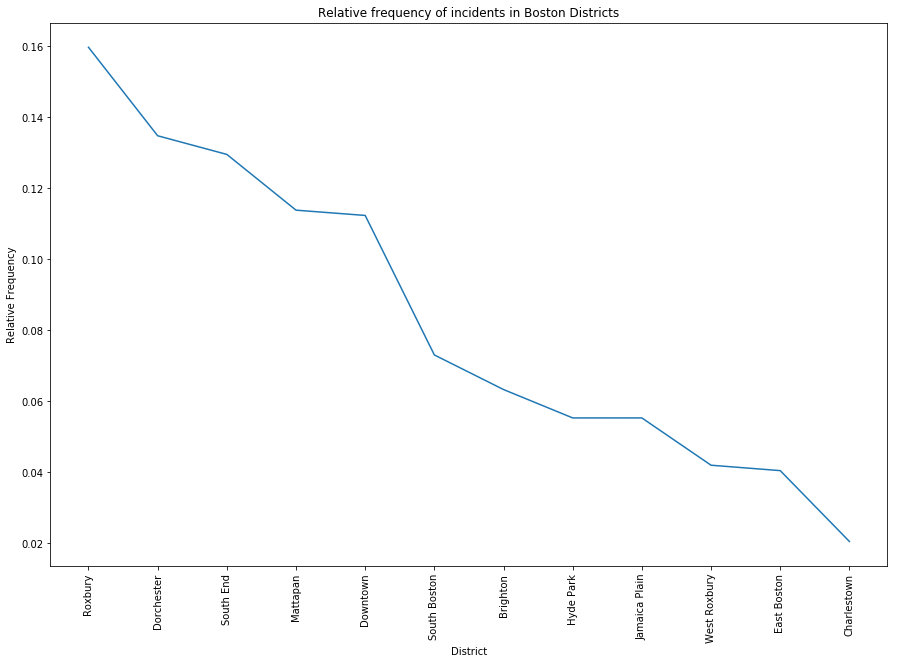

In [37]:
plot_hist(processed_data.DISTRICT_NAME.value_counts(ascending=False, normalize=True, sort=True), 
          y_label="Relative Frequency", x_label="District", 
          title="Relative frequency of incidents in Boston Districts")

Now, let us jump right into the question that we aim to answer.

### 1. What are the top 10 crimes classified for each district?

In [39]:
def get_top_k_crimes_district(data, district, k=10):
    subset_data = data[data.DISTRICT_NAME == district]
    subset_data = subset_data.OFFENSE_CODE_GROUP.value_counts(normalize=True, 
                                                              dropna=True).sort_values(ascending=False)[:k]
    return subset_data

In [131]:
# Get unique district names
district_names = processed_data.DISTRICT_NAME.dropna().sort_values().unique()
n_cols = 2
n_rows = (len(district_names) // 2) + (len(district_names) % 2)

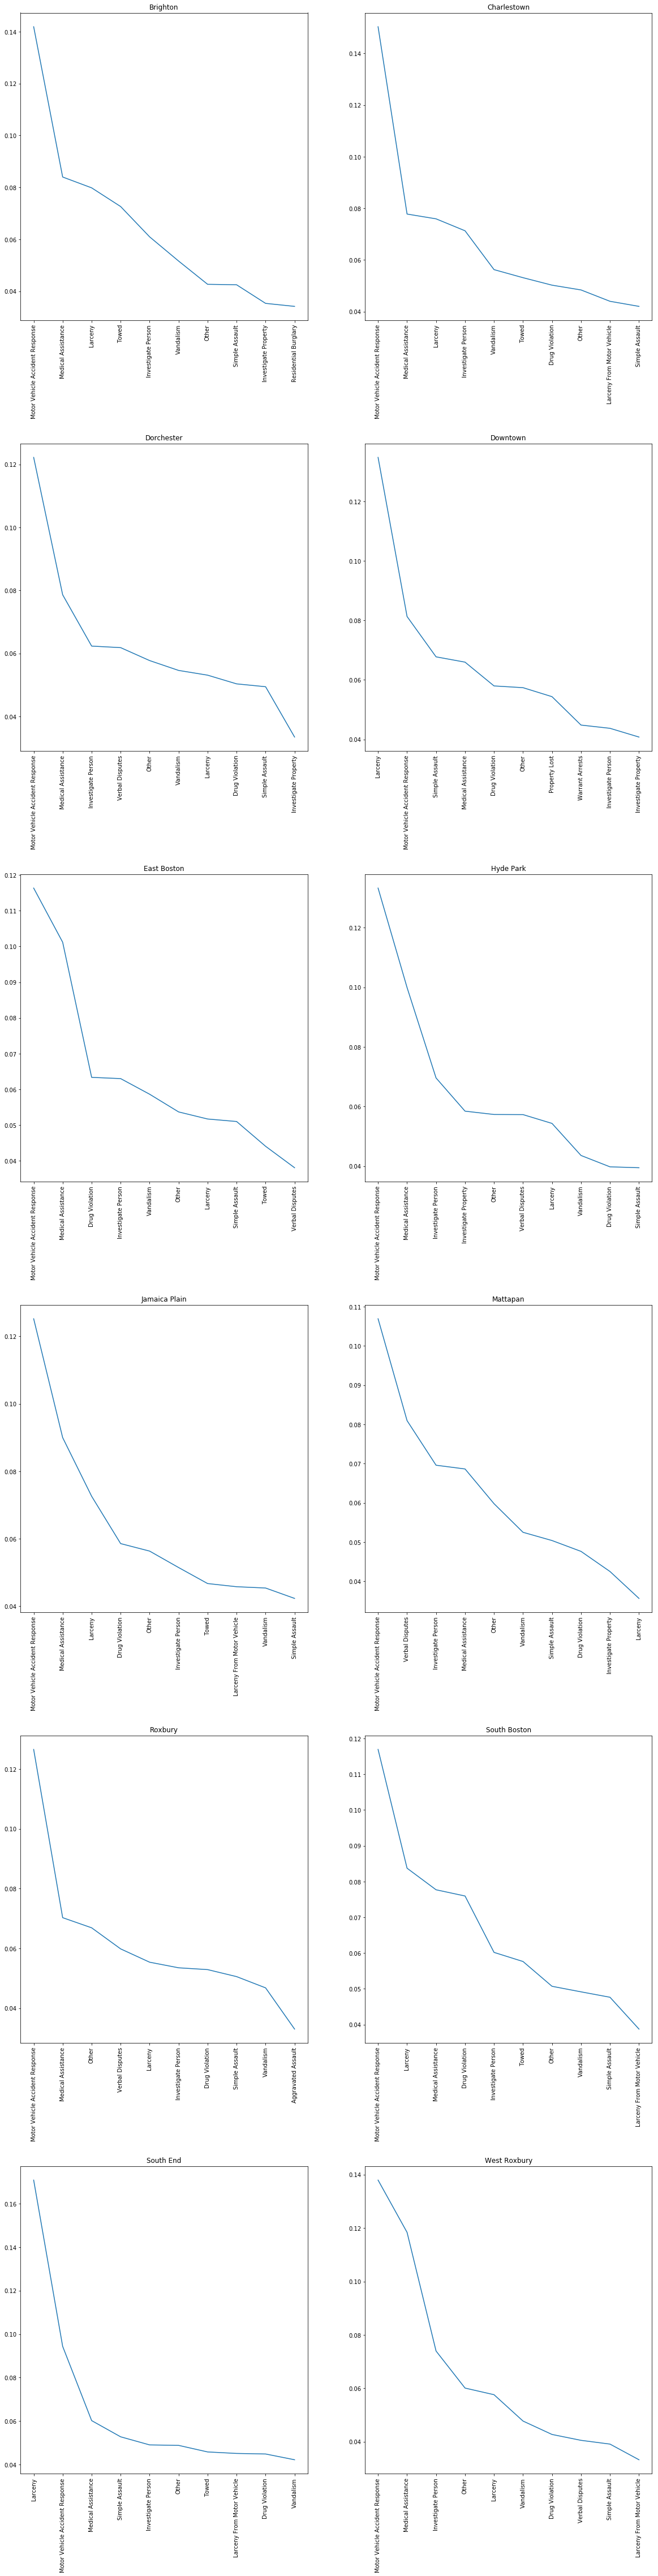

In [132]:
plt.rcParams['figure.figsize'] = [20, 80]
fig, axs = plt.subplots(n_rows, n_cols)
x = 0
y = 0
for name in district_names:
    val = get_top_k_crimes_district(processed_data, name)
    _ = axs[x, y].plot(val)
    _ = axs[x, y].set_xticklabels(list(val.index), rotation=90)
    _ = axs[x, y].set_title(name)
    plt.subplots_adjust(hspace = .4)
    y = (y + 1) % 2
    if not y:
        x += 1

### 2. What are the top 10 crimes classified according to different times of the day?

For this question, we would mainly focus on binning the day into 6 bins.

In [136]:
bin_labels = ["0-3", "4-7", "8-11", "12-15", "16-19", "20-23"]
bins = {i : bin_labels[i // 4] for i in range(24)}
temp_data = processed_data.copy()
temp_data['hbins'] = temp_data.HOUR.replace(bins)

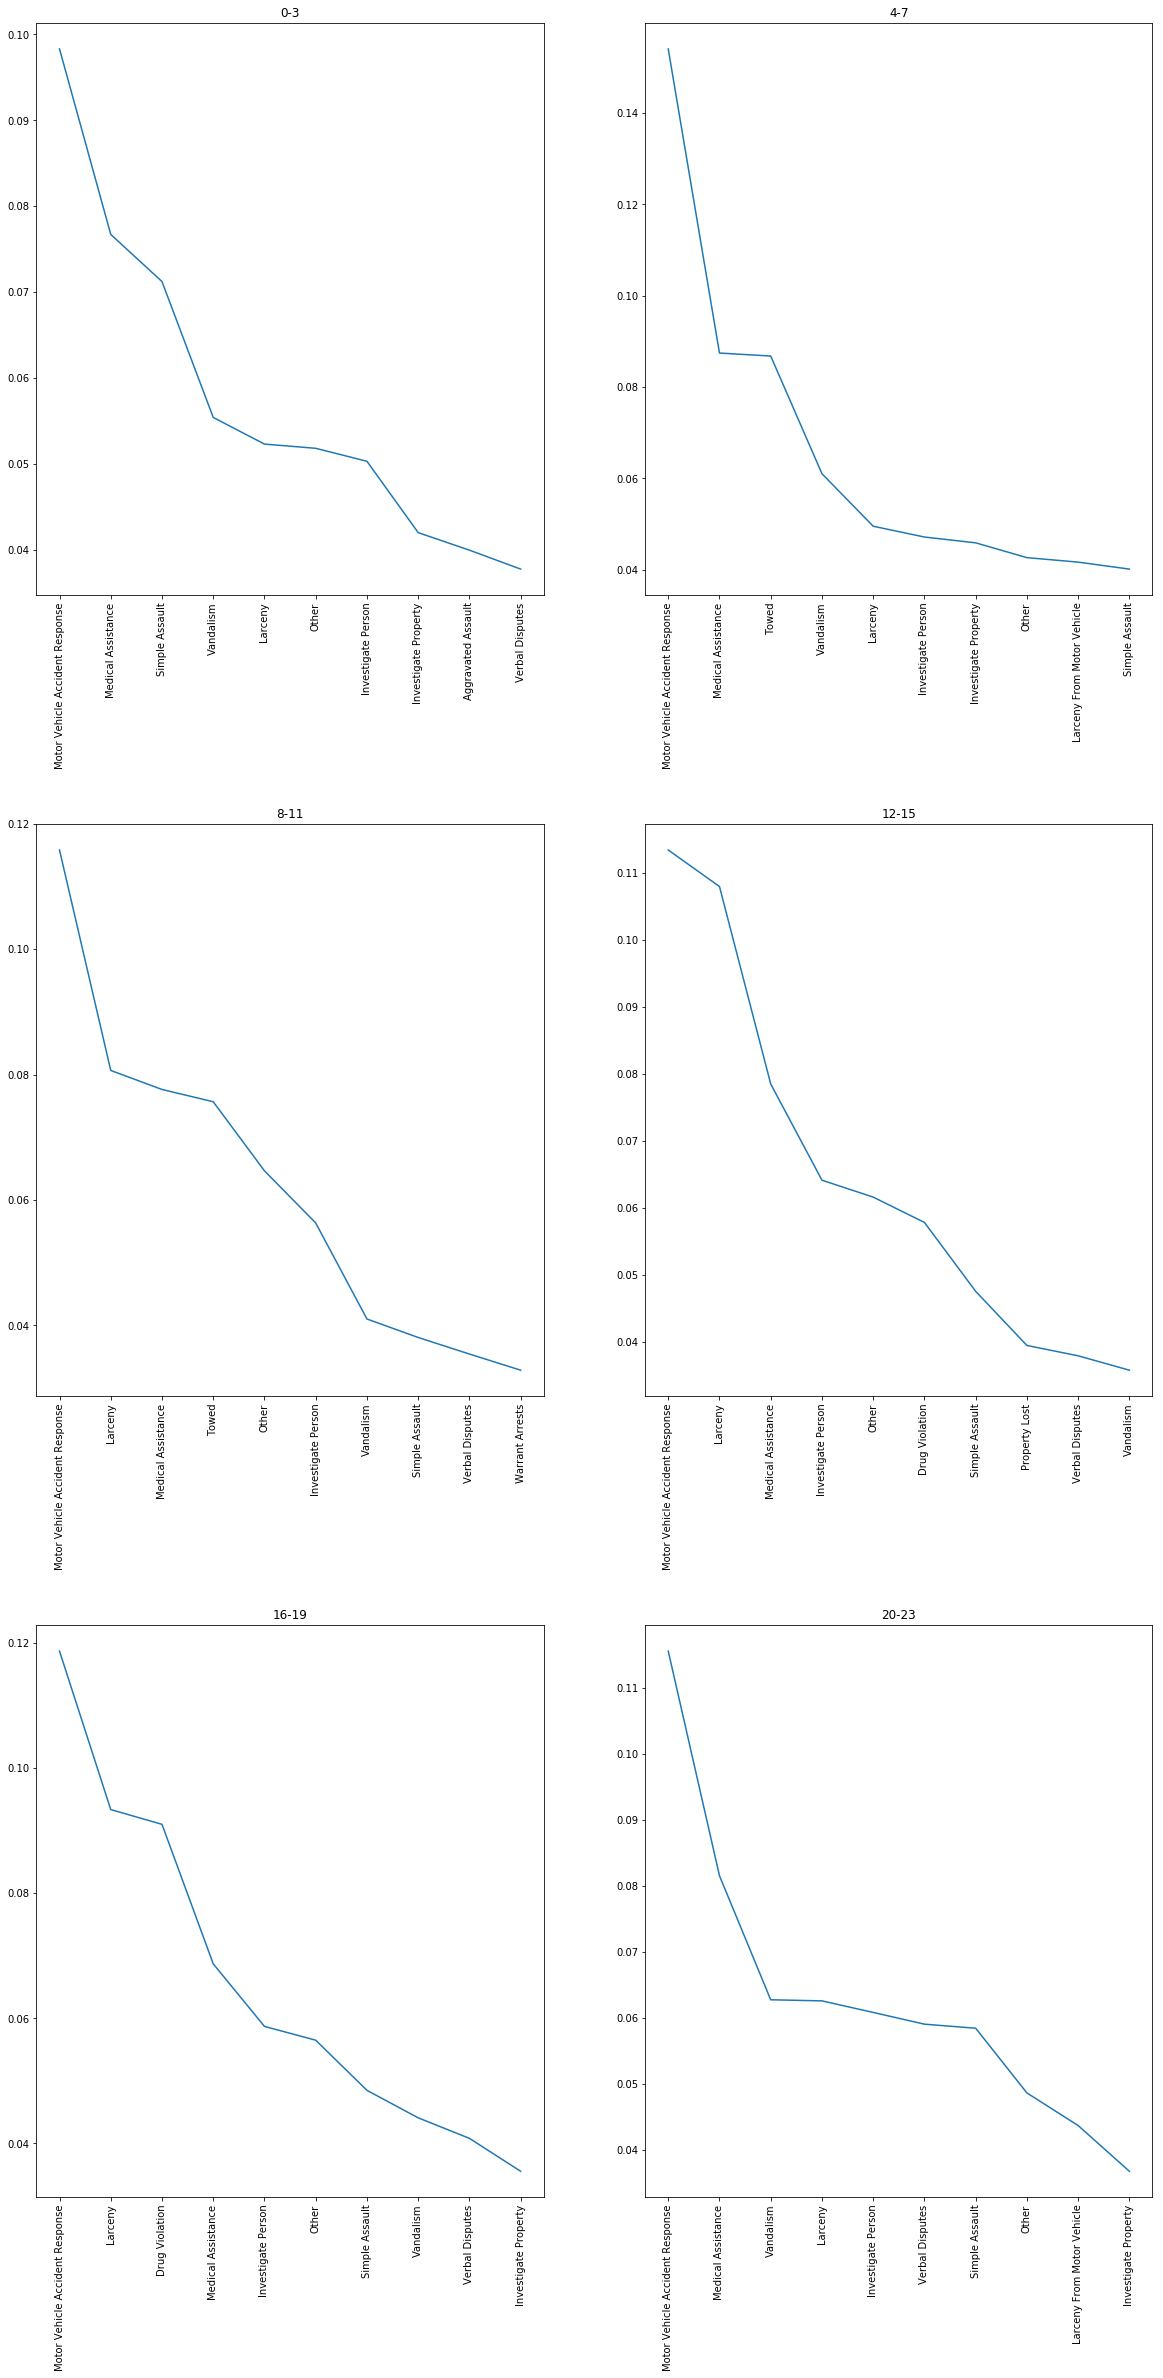

In [140]:
def get_top_k_crimes_hour(data, hbin, k=10):
    subset_data = data[data.hbins == hbin]
    subset_data = subset_data.OFFENSE_CODE_GROUP.value_counts(normalize=True, 
                                                              dropna=True).sort_values(ascending=False)[:k]
    return subset_data

n_cols = 2
n_rows = (len(bin_labels) // 2) + (len(bin_labels) % 2)

plt.rcParams['figure.figsize'] = [20, 40]
fig, axs = plt.subplots(n_rows, n_cols)
x = 0
y = 0
for hbin in bin_labels:
    val = get_top_k_crimes_hour(temp_data, hbin)
    _ = axs[x, y].plot(val)
    _ = axs[x, y].set_xticklabels(list(val.index), rotation=90)
    _ = axs[x, y].set_title(hbin)
    plt.subplots_adjust(hspace = .4)
    y = (y + 1) % 2
    if not y:
        x += 1

### 3. What reported incidents are most commonly associated with a shooting?

First, we try to see what time of the day is shooting very common.

In [141]:
temp_data[temp_data.SHOOTING].hbins.value_counts()

20-23    461
0-3      363
16-19    325
12-15    192
8-11      75
4-7       61
Name: hbins, dtype: int64

Next, we try to analyze the crimes most commonly associated with a shooting.

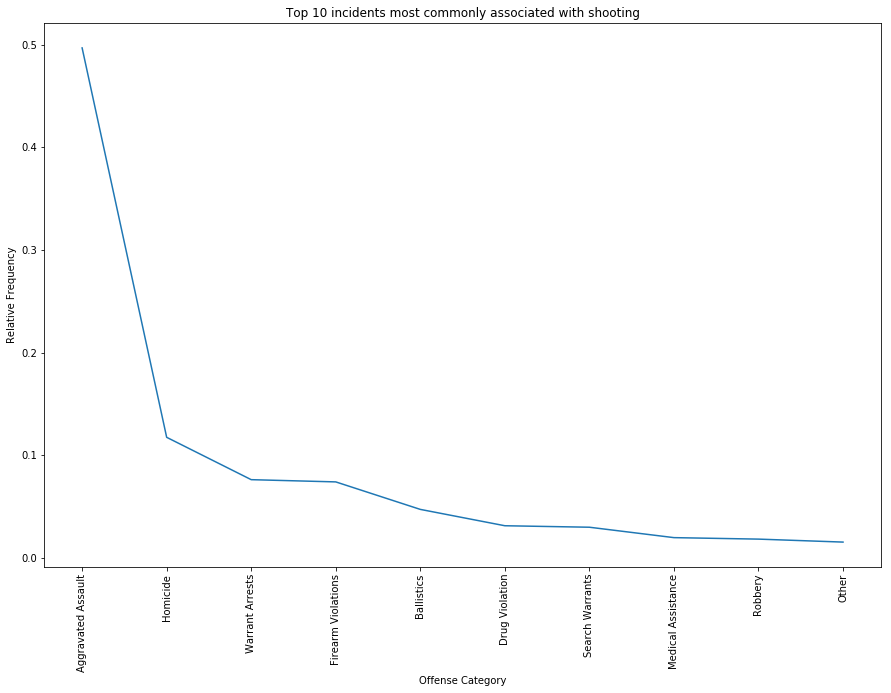

In [146]:
shooting_data_code = processed_data[processed_data.SHOOTING].OFFENSE_CODE_GROUP.value_counts(ascending=False, 
                                                                                             normalize=True, 
                                                                                             sort=True, 
                                                                                             dropna=True)
plot_hist(data=shooting_data_code, y_label="Relative Frequency", x_label="Offense Category", 
          title="Top 10 incidents most commonly associated with shooting", top=10)

We repeat the above experiment to identify districts most commonly associated with a shooting incident.

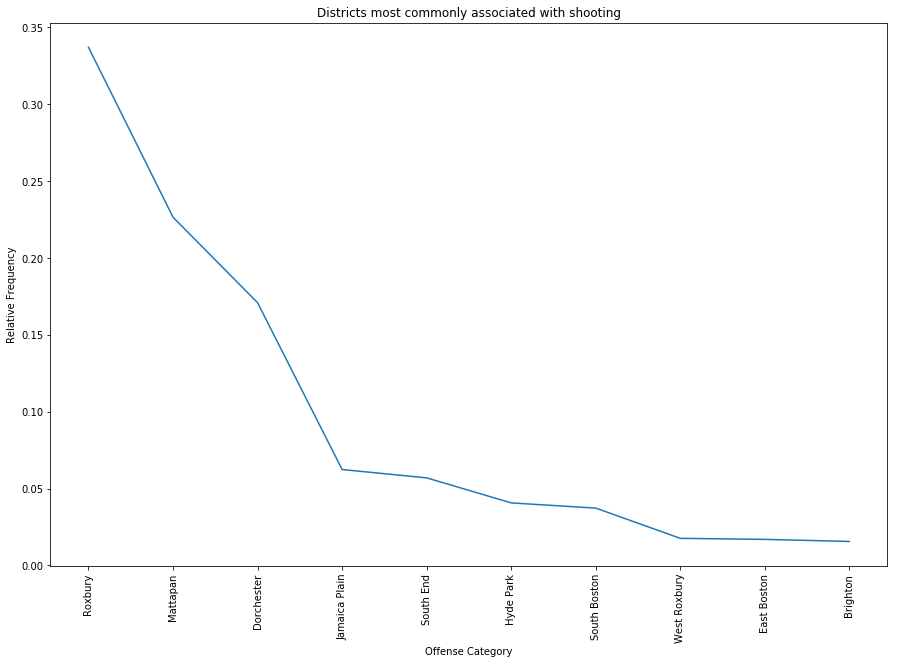

In [149]:
shooting_data_district = processed_data[processed_data.SHOOTING].DISTRICT_NAME.value_counts(ascending=False, 
                                                                                            normalize=True, 
                                                                                            sort=True, 
                                                                                            dropna=True)
plot_hist(data=shooting_data_district, y_label="Relative Frequency", x_label="Offense Category", 
          title="Districts most commonly associated with shooting", top=10)

Interstingly, Roxbury, Mattapan and Dorchester are again on the top in this list.

### 4. How have certain crimes changed in the past few years?

Has shooting incidents reduced in the past few years?